In [1]:
import sys
import pickle
import numpy as np
import pandas as pd
import torch

import time

sys.path.append('..')
from src.utils import *
from src.models import *
from src.configs import *

from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
rcParams.update(fig_params)

import warnings

%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

## Set device

In [2]:
DEVICE = 'cuda:3' if torch.cuda.is_available() else 'cpu'
print('Using device:', DEVICE)
DTYPE = torch.float64

Using device: cuda:3


## Massive experiment (sensitivity wrt number of features)

In [3]:
class MultiRidgeAutograd(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, λ):
        theta_hat = torch.linalg.lstsq(X_train.T @ X_train + N_train * torch.diag(λ)@torch.diag(λ), X_train.T @ Y_train)[0]
        Y_valid_hat = X_valid @ theta_hat
        return (1/(2*N_valid)) * torch.linalg.norm(Y_valid_hat - Y_valid)**2
    
class Function(torch.autograd.Function):
    @staticmethod
    def forward(ctx, λ):
        theta_hat = torch.linalg.lstsq(X_train.T @ X_train + N_train * torch.diag(λ)@torch.diag(λ), X_train.T @ Y_train)[0]
        Y_valid_hat = X_valid @ theta_hat
        R = (Y_valid_hat - Y_valid)
        ctx.save_for_backward(λ, theta_hat, R)
        return (1/(2*N_valid)) * torch.linalg.norm(R)**2
    
    @staticmethod
    def backward(ctx, grad_output):
        λ, theta_hat, R = ctx.saved_tensors
        B = torch.linalg.lstsq((X_train.T @ X_train + N_train * torch.diag(λ)@torch.diag(λ)).T, X_valid.T @ R @ theta_hat.T)[0]
        return -(N_train/N_valid) * torch.diagonal(torch.diag(λ)@B + B@torch.diag(λ))

class MultiRidgeAnalytic(nn.Module):
    def __init__(self):
        super(MultiRidgeAnalytic, self).__init__()

    def forward(self, λ):
        return Function.apply(λ)

In [4]:
number_of_features_list = list(np.logspace(1,4))
mc_runs = 10
df = pd.DataFrame(data=0.0, columns=['number_of_features'] + \
                                    [f'time_analytic_run{j}' for j in range(mc_runs)] + \
                                    [f'time_autograd_run{j}' for j in range(mc_runs)] + \
                                    [f'gpu_memory_analytic_run{j}' for j in range(mc_runs)] + \
                                    [f'gpu_memory_autograd_run{j}' for j in range(mc_runs)] + \
                                    [f'norm_difference_run{j}' for j in range(mc_runs)], index=range(len(number_of_features_list)))

for i,number_of_features in enumerate(tqdm(number_of_features_list, total=len(number_of_features_list))):
    for j in tqdm(range(mc_runs), total=mc_runs):
        
        rng = np.random.default_rng(seed=42*(j+1))

        N = 1000
        M = 10
        D = int(number_of_features)
        df.loc[i, 'number_of_features'] = D
        N_train, N_valid = int(N*0.8), int(N*0.2)
        dtype = torch.float64
        np_dtype=np.float64

        ### Initialization
        X_train = torch.tensor(rng.standard_normal(size=(N_train, D), dtype=np_dtype), device=DEVICE, dtype=dtype, requires_grad=True)
        X_valid = torch.tensor(rng.standard_normal(size=(N_valid, D), dtype=np_dtype), device=DEVICE, dtype=dtype, requires_grad=True)
        Y_train = torch.tensor(rng.standard_normal(size=(N_train, M), dtype=np_dtype), device=DEVICE, dtype=dtype, requires_grad=True)
        Y_valid = torch.tensor(rng.standard_normal(size=(N_valid, M), dtype=np_dtype), device=DEVICE, dtype=dtype, requires_grad=True)
        λ = torch.tensor(rng.standard_normal(size=D, dtype=np_dtype), device=DEVICE, dtype=dtype, requires_grad=True)
        Id = torch.eye(D, device=DEVICE, dtype=dtype, requires_grad=True)
        ones = torch.ones(D,1, device=DEVICE, dtype=dtype, requires_grad=True)
        
        ### Autograd
        model = MultiRidgeAutograd()
        gradient_loss, gpu_memory, gpu_time = log_mem(model, λ, exp='Autograd')
        df.loc[i, f'time_autograd_run{j}'] = gpu_time
        df.loc[i, f'gpu_memory_autograd_run{j}'] = gpu_memory/1024**3
        gradient_loss_automatic = gradient_loss.detach().cpu().numpy()
        del model, gradient_loss
        
        λ.grad.zero_()
        
        ### Analytic
        model = MultiRidgeAnalytic()
        gradient_loss, gpu_memory, gpu_time = log_mem(model, λ, exp='Analytic')
        df.loc[i, f'time_analytic_run{j}'] = gpu_time
        df.loc[i, f'gpu_memory_analytic_run{j}'] = gpu_memory/1024**3
        gradient_loss_analytic = gradient_loss.detach().cpu().numpy()
        del model, gradient_loss
        
        df.loc[i, f'norm_difference_run{j}'] = np.linalg.norm(gradient_loss_automatic - gradient_loss_analytic)
        
        ### Release GPU memory
        del X_train, X_valid, Y_train, Y_valid, λ, Id, ones
        torch.cuda.empty_cache()
    
    print('-'*100)
    print('-'*100)
    print(f'Number of features: {D}')
    print('Time analytic: {:.3f} +- {:.3f}'.format(df.loc[i, [f'time_analytic_run{j}' for j in range(mc_runs)]].mean(), df.loc[i, [f'time_analytic_run{j}' for j in range(mc_runs)]].std()))
    print('Time autograd: {:.3f} +- {:.3f}'.format(df.loc[i, [f'time_autograd_run{j}' for j in range(mc_runs)]].mean(), df.loc[i, [f'time_autograd_run{j}' for j in range(mc_runs)]].std()))
    print('Memory analytic: {:.3f} +- {:.3f}'.format(df.loc[i, [f'gpu_memory_analytic_run{j}' for j in range(mc_runs)]].mean(), df.loc[i, [f'gpu_memory_analytic_run{j}' for j in range(mc_runs)]].std()))
    print('Memory autograd: {:.3f} +- {:.3f}'.format(df.loc[i, [f'gpu_memory_autograd_run{j}' for j in range(mc_runs)]].mean(), df.loc[i, [f'gpu_memory_autograd_run{j}' for j in range(mc_runs)]].std()))
    print('Norm difference: {:.2e} +- {:.2e}'.format(df.loc[i, [f'norm_difference_run{j}' for j in range(mc_runs)]].mean(), df.loc[i, [f'norm_difference_run{j}' for j in range(mc_runs)]].std()))

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 10
Time analytic: 0.002 +- 0.000
Time autograd: 0.003 +- 0.001
Memory analytic: 0.016 +- 0.000
Memory autograd: 0.016 +- 0.000
Norm difference: 3.84e-17 +- 9.60e-18


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 11
Time analytic: 0.001 +- 0.000
Time autograd: 0.002 +- 0.000
Memory analytic: 0.016 +- 0.000
Memory autograd: 0.016 +- 0.000
Norm difference: 3.54e-17 +- 1.84e-17


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 13
Time analytic: 0.002 +- 0.000
Time autograd: 0.003 +- 0.000
Memory analytic: 0.016 +- 0.000
Memory autograd: 0.016 +- 0.000
Norm difference: 5.25e-17 +- 1.76e-17


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 15
Time analytic: 0.001 +- 0.000
Time autograd: 0.003 +- 0.000
Memory analytic: 0.016 +- 0.000
Memory autograd: 0.016 +- 0.000
Norm difference: 5.23e-17 +- 1.97e-17


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 17
Time analytic: 0.001 +- 0.000
Time autograd: 0.003 +- 0.000
Memory analytic: 0.016 +- 0.000
Memory autograd: 0.016 +- 0.000
Norm difference: 6.33e-17 +- 1.89e-17


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 20
Time analytic: 0.002 +- 0.000
Time autograd: 0.003 +- 0.000
Memory analytic: 0.016 +- 0.000
Memory autograd: 0.016 +- 0.000
Norm difference: 9.05e-17 +- 2.70e-17


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 23
Time analytic: 0.002 +- 0.000
Time autograd: 0.004 +- 0.000
Memory analytic: 0.016 +- 0.000
Memory autograd: 0.016 +- 0.000
Norm difference: 9.01e-17 +- 5.32e-17


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 26
Time analytic: 0.002 +- 0.000
Time autograd: 0.004 +- 0.000
Memory analytic: 0.016 +- 0.000
Memory autograd: 0.016 +- 0.000
Norm difference: 1.07e-16 +- 3.53e-17


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 30
Time analytic: 0.002 +- 0.000
Time autograd: 0.005 +- 0.000
Memory analytic: 0.016 +- 0.000
Memory autograd: 0.016 +- 0.000
Norm difference: 1.35e-16 +- 4.58e-17


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 35
Time analytic: 0.002 +- 0.000
Time autograd: 0.009 +- 0.000
Memory analytic: 0.017 +- 0.000
Memory autograd: 0.017 +- 0.000
Norm difference: 1.15e-16 +- 2.71e-17


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 40
Time analytic: 0.002 +- 0.000
Time autograd: 0.009 +- 0.000
Memory analytic: 0.017 +- 0.000
Memory autograd: 0.017 +- 0.000
Norm difference: 1.34e-16 +- 3.16e-17


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 47
Time analytic: 0.002 +- 0.000
Time autograd: 0.011 +- 0.000
Memory analytic: 0.017 +- 0.000
Memory autograd: 0.017 +- 0.000
Norm difference: 1.47e-16 +- 3.40e-17


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 54
Time analytic: 0.002 +- 0.000
Time autograd: 0.012 +- 0.001
Memory analytic: 0.017 +- 0.000
Memory autograd: 0.017 +- 0.000
Norm difference: 1.74e-16 +- 3.34e-17


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 62
Time analytic: 0.002 +- 0.000
Time autograd: 0.012 +- 0.000
Memory analytic: 0.017 +- 0.000
Memory autograd: 0.017 +- 0.000
Norm difference: 1.84e-16 +- 3.26e-17


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 71
Time analytic: 0.002 +- 0.000
Time autograd: 0.019 +- 0.001
Memory analytic: 0.017 +- 0.000
Memory autograd: 0.017 +- 0.000
Norm difference: 2.56e-16 +- 2.58e-17


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 82
Time analytic: 0.003 +- 0.000
Time autograd: 0.020 +- 0.000
Memory analytic: 0.017 +- 0.000
Memory autograd: 0.017 +- 0.000
Norm difference: 2.85e-16 +- 3.70e-17


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 95
Time analytic: 0.003 +- 0.000
Time autograd: 0.021 +- 0.001
Memory analytic: 0.018 +- 0.000
Memory autograd: 0.018 +- 0.000
Norm difference: 3.23e-16 +- 3.13e-17


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 109
Time analytic: 0.003 +- 0.000
Time autograd: 0.030 +- 0.001
Memory analytic: 0.018 +- 0.000
Memory autograd: 0.018 +- 0.000
Norm difference: 4.05e-16 +- 5.72e-17


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 126
Time analytic: 0.004 +- 0.000
Time autograd: 0.031 +- 0.001
Memory analytic: 0.018 +- 0.000
Memory autograd: 0.018 +- 0.000
Norm difference: 4.76e-16 +- 7.79e-17


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 145
Time analytic: 0.003 +- 0.000
Time autograd: 0.048 +- 0.001
Memory analytic: 0.018 +- 0.000
Memory autograd: 0.018 +- 0.000
Norm difference: 6.06e-16 +- 6.38e-17


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 167
Time analytic: 0.004 +- 0.000
Time autograd: 0.061 +- 0.001
Memory analytic: 0.019 +- 0.000
Memory autograd: 0.019 +- 0.000
Norm difference: 7.21e-16 +- 6.66e-17


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 193
Time analytic: 0.004 +- 0.000
Time autograd: 0.074 +- 0.002
Memory analytic: 0.019 +- 0.000
Memory autograd: 0.019 +- 0.000
Norm difference: 9.70e-16 +- 6.54e-17


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 222
Time analytic: 0.004 +- 0.000
Time autograd: 0.077 +- 0.001
Memory analytic: 0.020 +- 0.000
Memory autograd: 0.020 +- 0.000
Norm difference: 1.13e-15 +- 1.11e-16


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 255
Time analytic: 0.005 +- 0.000
Time autograd: 0.093 +- 0.002
Memory analytic: 0.020 +- 0.000
Memory autograd: 0.020 +- 0.000
Norm difference: 1.44e-15 +- 1.11e-16


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 294
Time analytic: 0.006 +- 0.000
Time autograd: 0.140 +- 0.002
Memory analytic: 0.021 +- 0.000
Memory autograd: 0.021 +- 0.000
Norm difference: 2.00e-15 +- 1.95e-16


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 339
Time analytic: 0.008 +- 0.000
Time autograd: 0.162 +- 0.003
Memory analytic: 0.022 +- 0.000
Memory autograd: 0.022 +- 0.000
Norm difference: 2.58e-15 +- 2.30e-16


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 390
Time analytic: 0.009 +- 0.000
Time autograd: 0.218 +- 0.003
Memory analytic: 0.023 +- 0.000
Memory autograd: 0.023 +- 0.000
Norm difference: 3.19e-15 +- 2.18e-16


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 449
Time analytic: 0.011 +- 0.001
Time autograd: 0.264 +- 0.004
Memory analytic: 0.024 +- 0.000
Memory autograd: 0.024 +- 0.000
Norm difference: 4.39e-15 +- 1.96e-16


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 517
Time analytic: 0.013 +- 0.000
Time autograd: 0.340 +- 0.006
Memory analytic: 0.026 +- 0.000
Memory autograd: 0.026 +- 0.000
Norm difference: 6.33e-15 +- 6.48e-16


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 596
Time analytic: 0.016 +- 0.000
Time autograd: 0.396 +- 0.004
Memory analytic: 0.028 +- 0.000
Memory autograd: 0.028 +- 0.000
Norm difference: 8.88e-15 +- 8.70e-16


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 686
Time analytic: 0.019 +- 0.000
Time autograd: 0.524 +- 0.008
Memory analytic: 0.030 +- 0.000
Memory autograd: 0.030 +- 0.000
Norm difference: 1.29e-14 +- 1.00e-15


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 790
Time analytic: 0.026 +- 0.000
Time autograd: 0.666 +- 0.008
Memory analytic: 0.033 +- 0.000
Memory autograd: 0.033 +- 0.000
Norm difference: 1.97e-14 +- 2.00e-15


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 910
Time analytic: 0.034 +- 0.000
Time autograd: 0.864 +- 0.009
Memory analytic: 0.037 +- 0.000
Memory autograd: 0.037 +- 0.000
Norm difference: 2.97e-14 +- 2.17e-15


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 1048
Time analytic: 0.045 +- 0.000
Time autograd: 1.090 +- 0.011
Memory analytic: 0.040 +- 0.000
Memory autograd: 0.040 +- 0.000
Norm difference: 4.98e-14 +- 6.81e-15


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 1206
Time analytic: 0.061 +- 0.000
Time autograd: 1.397 +- 0.010
Memory analytic: 0.045 +- 0.000
Memory autograd: 0.045 +- 0.000
Norm difference: 8.48e-14 +- 9.10e-15


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 1389
Time analytic: 0.088 +- 0.000
Time autograd: 2.141 +- 0.013
Memory analytic: 0.051 +- 0.000
Memory autograd: 0.051 +- 0.000
Norm difference: 1.44e-13 +- 1.40e-14


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 1599
Time analytic: 0.124 +- 0.000
Time autograd: 2.865 +- 0.029
Memory analytic: 0.060 +- 0.000
Memory autograd: 0.060 +- 0.000
Norm difference: 2.72e-13 +- 2.87e-14


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 1842
Time analytic: 0.178 +- 0.000
Time autograd: 3.854 +- 0.018
Memory analytic: 0.071 +- 0.000
Memory autograd: 0.071 +- 0.000
Norm difference: 4.75e-13 +- 6.62e-14


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 2120
Time analytic: 0.253 +- 0.000
Time autograd: 5.061 +- 0.032
Memory analytic: 0.082 +- 0.000
Memory autograd: 0.082 +- 0.000
Norm difference: 9.67e-13 +- 1.12e-13


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 2442
Time analytic: 0.368 +- 0.000
Time autograd: 6.947 +- 0.064
Memory analytic: 0.097 +- 0.000
Memory autograd: 0.097 +- 0.000
Norm difference: 2.07e-12 +- 4.12e-13


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 2811
Time analytic: 0.531 +- 0.001
Time autograd: 14.733 +- 0.093
Memory analytic: 0.118 +- 0.000
Memory autograd: 0.118 +- 0.000
Norm difference: 4.10e-12 +- 5.29e-13


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 3237
Time analytic: 0.788 +- 0.001
Time autograd: 20.391 +- 0.146
Memory analytic: 0.144 +- 0.000
Memory autograd: 0.144 +- 0.000
Norm difference: 8.66e-12 +- 5.79e-13


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 3727
Time analytic: 1.167 +- 0.000
Time autograd: 27.540 +- 0.178
Memory analytic: 0.175 +- 0.000
Memory autograd: 0.175 +- 0.000
Norm difference: 1.76e-11 +- 2.96e-12


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 4291
Time analytic: 1.759 +- 0.002
Time autograd: 40.783 +- 0.211
Memory analytic: 0.217 +- 0.000
Memory autograd: 0.217 +- 0.000
Norm difference: 3.96e-11 +- 6.44e-12


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 4941
Time analytic: 2.588 +- 0.000
Time autograd: 54.403 +- 0.273
Memory analytic: 0.272 +- 0.000
Memory autograd: 0.272 +- 0.000
Norm difference: 9.01e-11 +- 1.48e-11


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 5689
Time analytic: 3.822 +- 0.000
Time autograd: 98.336 +- 0.550
Memory analytic: 0.342 +- 0.000
Memory autograd: 0.342 +- 0.000
Norm difference: 2.03e-10 +- 3.05e-11


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 6551
Time analytic: 5.794 +- 0.000
Time autograd: 134.155 +- 0.889
Memory analytic: 0.434 +- 0.000
Memory autograd: 0.434 +- 0.000
Norm difference: 4.61e-10 +- 1.10e-10


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 7543
Time analytic: 8.656 +- 0.001
Time autograd: 192.242 +- 1.045
Memory analytic: 0.553 +- 0.000
Memory autograd: 0.553 +- 0.000
Norm difference: 1.00e-09 +- 1.58e-10


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 8685
Time analytic: 13.100 +- 0.025
Time autograd: 318.311 +- 2.447
Memory analytic: 0.710 +- 0.000
Memory autograd: 0.710 +- 0.000
Norm difference: 1.91e-09 +- 3.53e-10


  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Number of features: 10000
Time analytic: 20.105 +- 0.053
Time autograd: 462.319 +- 3.123
Memory analytic: 0.912 +- 0.000
Memory autograd: 0.912 +- 0.000
Norm difference: 4.36e-09 +- 7.54e-10


In [5]:
os.makedirs(os.path.join('..', 'results', 'timing'), exist_ok=True)
folder = os.path.join('..', 'results', 'timing')
filename = 'timing_experiment_float64.pickle'
df.to_pickle(os.path.join(folder, filename))

In [6]:
df = pd.read_pickle(os.path.join(folder, filename))

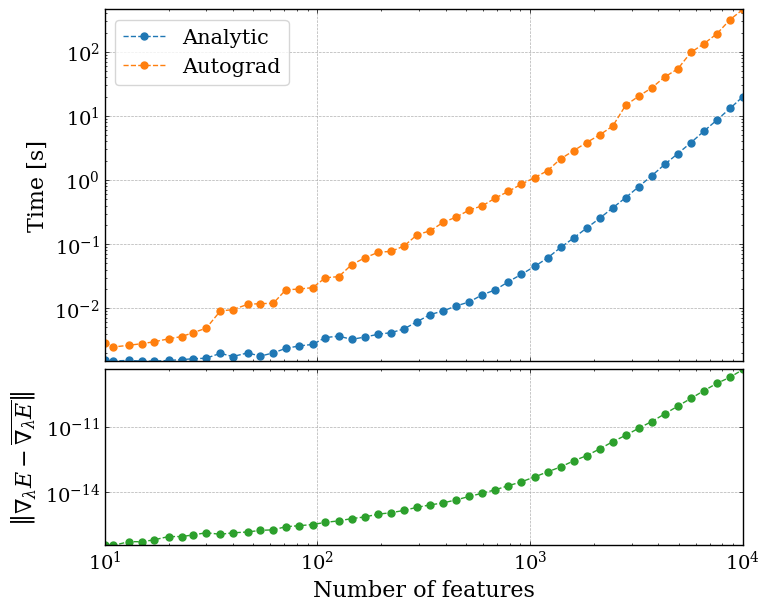

In [10]:
fig_params['axes.labelsize'] = 16
fig_params['xtick.labelsize'] = 14
fig_params['ytick.labelsize'] = 14
fig_params['legend.fontsize'] = 15
fig_params['axes.grid'] = True
rcParams.update(fig_params)

tmp = df.copy()
fig = plt.figure(constrained_layout=True, figsize=(14, 6))
gs = gridspec.GridSpec(3, 2, figure=fig)
ax0 = plt.subplot(gs[:2, :1])

ax0.plot(tmp.number_of_features.values, tmp[[f'time_analytic_run{j}' for j in range(mc_runs)]].mean(axis=1), marker='.', linestyle='--', markersize=10, label='Analytic')
ax0.plot(tmp.number_of_features.values, tmp[[f'time_autograd_run{j}' for j in range(mc_runs)]].mean(axis=1), marker='.', linestyle='--', markersize=10, label='Autograd')

ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_ylabel('Time [s]', fontsize=16)
plt.setp(ax0.get_xticklabels(), visible=False)
ax0.legend()

ax1 = plt.subplot(gs[2, :1], sharex=ax0)
ax1.plot(tmp.number_of_features.values, tmp[[f'norm_difference_run{j}' for j in range(mc_runs)]].mean(axis=1), marker='.', linestyle='--', markersize=10, color='tab:green')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Number of features', fontsize=16)
ax1.set_ylabel(r'$\left\| \nabla_{\lambda}E - \overline{\nabla_{\lambda}E} \right\|$', fontsize=16)

plt.show()

In [11]:
FIG_SIZE = (12, 6)
SAVE_FIG = True
FIG_FMT = 'pdf'
TRANSPARENT_PNG=True

save_fig(
    fig,
    'float64',
    fig_dir=os.path.join('..','figures'),
    fig_fmt=FIG_FMT,
    save=SAVE_FIG, 
    fig_size=FIG_SIZE,
    transparent_png=TRANSPARENT_PNG,
)